# snnTorch Test - Truncated BPTT
### By Jason K. Eshraghian

## Gradient-based Learning in Spiking Neural Networks

In [1]:
# Install the test PyPi Distribution of snntorch
!pip install -i https://test.pypi.org/simple/ snntorch

Looking in indexes: https://test.pypi.org/simple/


## 1. Setting up the Static MNIST Dataset
### 1.1. Import packages and setup environment

In [1]:
import snntorch as snn
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt

### 1.2 Define network and SNN parameters

In [2]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Training Parameters
batch_size=128
data_path='/data/mnist'

# Temporal Dynamics
num_steps = 25
time_step = 1e-3
tau_mem = 3e-3
tau_syn = 2.2e-3
alpha = float(np.exp(-time_step/tau_syn))
beta = float(np.exp(-time_step/tau_mem))

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### 1.3 Download MNIST Dataset

In [3]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

### 1.4 Create DataLoaders

In [4]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

## 2. Define Network
snnTorch treats neurons as activations with recurrent connections. This allows for smooth integration with PyTorch.
There are a few useful neuron models and surrogate gradient functions which approximate the gradient of spikes.

In [6]:
# from snntorch import surrogate
#
# spike_grad = surrogate.FastSigmoid.apply
# snn.slope = 50

The following network model no longer has a for-loop. That is performed in the feedforward pass along with optimization at each time step.

In [7]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

    # initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Stein(alpha=alpha, beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Stein(alpha=alpha, beta=beta)

    def forward(self, x, syn1, mem1, spk1, syn2, mem2):
        cur1 = self.fc1(x)
        spk1, syn1, mem1 = self.lif1(cur1, syn1, mem1)
        cur2 = self.fc2(spk1)
        spk2, syn2, mem2 = self.lif2(cur2, syn2, mem2)
        return syn1, mem1, spk1, syn2, mem2, spk2

net = Net().to(device)

## 3. Training
Time for training! Let's first define a couple of functions to print out test/train accuracy.

In [8]:
def print_batch_accuracy(data, targets, syn1, mem1, spk1, syn2, mem2, train=False):
  spk2_rec = []
  for step in range(num_steps):
    syn1, mem1, spk1, syn2, mem2, spk2 = net(data.view(batch_size, -1), syn1, mem1, spk1, syn2, mem2)
    spk2_rec.append(spk2)
  spk2_rec = torch.stack(spk2_rec, dim=0)
  _, idx = spk2_rec.sum(dim=0).max(1)
  acc = np.mean((targets == idx).detach().cpu().numpy())

  if train:
      print(f"Train Set Accuracy: {acc}")
  else:
      print(f"Test Set Accuracy: {acc}")

def train_printer(syn1, mem1, spk1, syn2, mem2, test_syn1, test_mem1, test_spk1, test_syn2, test_mem2):
    print(f"Epoch {epoch}, Minibatch {minibatch_counter}")
    print(f"Train Set Loss: {loss_hist[counter]}")
    print(f"Test Set Loss: {test_loss_hist[counter]}")
    print_batch_accuracy(data_it, targets_it, syn1, mem1, spk1, syn2, mem2, train=True)
    print_batch_accuracy(testdata_it, testtargets_it, test_syn1, test_mem1, test_spk1, test_syn2, test_mem2, train=False)
    print("\n")


### 3.1 Training Loop

In [9]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-4, betas=(0.9, 0.999))
log_softmax_fn = nn.LogSoftmax(dim=-1)
loss_fn = nn.NLLLoss()

test_data = itertools.cycle(test_loader)

loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(5):
    train_batch = iter(train_loader)

    # Minibatch training loop
    minibatch_counter = 0
    for data_it, targets_it in train_batch:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        # Test set iterator
        testdata_it, testtargets_it = next(test_data)
        testdata_it = testdata_it.to(device)
        testtargets_it = testtargets_it.to(device)

        # initialization
        spk1, syn1, mem1 = net.lif1.init_stein(batch_size, num_hidden)
        spk2, syn2, mem2 = net.lif2.init_stein(batch_size, num_outputs)

        # test: initialization
        test_spk1, test_syn1, test_mem1 = net.lif1.init_stein(batch_size, num_hidden)
        test_spk2, test_syn2, test_mem2 = net.lif2.init_stein(batch_size, num_outputs)

        # training loop
        step_counter = 0
        for steps in range(num_steps):
            syn1, mem1, spk1, syn2, mem2, spk2 = net(data_it.view(batch_size, -1), syn1, mem1, spk1, syn2, mem2)

            # loss p/timestep --- can try truncated approach too
            log_p_y = log_softmax_fn(mem2) # mem2 = 128 x 10
            loss_val = loss_fn(log_p_y, targets_it) # targets_it = 128
            loss_hist.append(loss_val.item())

            # Gradient calculation - detach states so gradient can flow
            optimizer.zero_grad()
            loss_val.backward()

            # Weight Update
            # nn.utils.clip_grad_norm_(net.parameters(), 1) # gradient clipping
            optimizer.step()

            # Detach for next update - test which of these variables don't have to be detached
            syn1.detach_()
            mem1.detach_()
            spk1.detach_()
            syn2.detach_()
            mem2.detach_()

            # Test set forward pass
            test_syn1, test_mem1, test_spk1, test_syn2, test_mem2, test_spk2  = net(testdata_it.view(batch_size, -1), test_syn1, test_mem1, test_spk1, test_syn2, test_mem2) ### WAY TOO MANY VARS

            # Test set loss
            log_p_ytest = log_softmax_fn(test_mem2)
            loss_val_test = loss_fn(log_p_ytest, testtargets_it)
            test_loss_hist.append(loss_val_test.item())


            # Print test/train loss/accuracy
            if step_counter == 24:
                train_printer(syn1, mem1, spk1, syn2, mem2, test_syn1, test_mem1, test_spk1, test_syn2, test_mem2) ## THIS IS A JOKE
            step_counter += 1
            counter +=1

        minibatch_counter += 1

loss_hist_true_grad = loss_hist
test_loss_hist_true_grad = test_loss_hist

Epoch 0, Minibatch 0
Train Set Loss: 1.7495200634002686
Test Set Loss: 1.9518725872039795
Train Set Accuracy: 0.4375
Test Set Accuracy: 0.3515625


Epoch 0, Minibatch 1
Train Set Loss: 1.3979709148406982
Test Set Loss: 1.5701136589050293
Train Set Accuracy: 0.625
Test Set Accuracy: 0.5234375


Epoch 0, Minibatch 2
Train Set Loss: 1.026261568069458
Test Set Loss: 1.1336437463760376
Train Set Accuracy: 0.78125
Test Set Accuracy: 0.703125


Epoch 0, Minibatch 3
Train Set Loss: 0.9658181667327881
Test Set Loss: 1.1051888465881348
Train Set Accuracy: 0.8046875
Test Set Accuracy: 0.6640625


Epoch 0, Minibatch 4
Train Set Loss: 0.7896397709846497
Test Set Loss: 0.905153751373291
Train Set Accuracy: 0.796875
Test Set Accuracy: 0.71875


Epoch 0, Minibatch 5
Train Set Loss: 0.6378481984138489
Test Set Loss: 0.9468184113502502
Train Set Accuracy: 0.875
Test Set Accuracy: 0.734375


Epoch 0, Minibatch 6
Train Set Loss: 0.746235191822052
Test Set Loss: 0.9170961976051331
Train Set Accuracy: 0.820

KeyboardInterrupt: 

## 4. Results
### 4.1 Plot Training/Test Loss

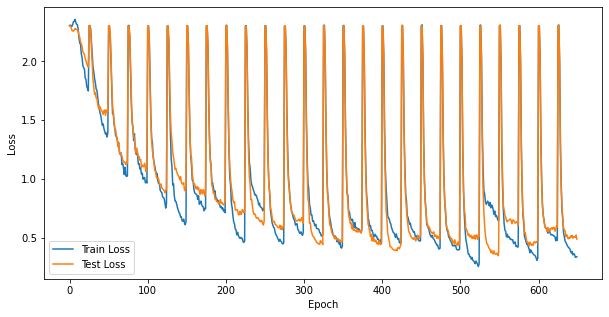

In [10]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### 4.2 Test Set Accuracy
This function just iterates over all minibatches to obtain a measure of accuracy over the full 10,000 samples in the test set.

In [ ]:
total = 0
correct = 0
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    # If current batch matches batch_size, just do the usual thing
    if images.size()[0] == batch_size:
      outputs, _ = net(images.view(batch_size, -1))

    # If current batch does not match batch_size (e.g., is the final minibatch),
    # modify batch_size in a temp variable and restore it at the end of the else block
    else:
      temp_bs = batch_size
      batch_size = images.size()[0]
      outputs, _ = net(images.view(images.size()[0], -1))
      batch_size = temp_bs

    _, predicted = outputs.sum(dim=0).max(1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total}%")

Voila! That's it for static MNIST.

## 5. Spiking MNIST
Part of the appeal of SNNs is their ability to handle time-varying spiking data. So let's use rate-coding to convert MNIST into spiking MNIST using the `spikegen` module in the previous tutorial, and train our network with that instead.

In [ ]:
from snntorch import spikegen

# MNIST to spiking-MNIST
spike_data, spike_targets = spikegen.rate(data_it, targets_it, num_outputs=num_outputs, num_steps=num_steps, gain=1,
                                          offset=0, convert_targets=False, temporal_targets=False)

### 5.1 Visualiser
Just so you're damn sure it's a spiking input.

In [ ]:
!pip install celluloid # matplotlib animations made easy

In [ ]:
from celluloid import Camera
from IPython.display import HTML

# Animator
spike_data_sample = spike_data[:, 0, 0].cpu()

fig, ax = plt.subplots()
camera = Camera(fig)
plt.axis('off')

for step in range(num_steps):
    im = ax.imshow(spike_data_sample[step, :, :], cmap='plasma')
    camera.snap()

# interval=40 specifies 40ms delay between frames
a = camera.animate(interval=40)
HTML(a.to_html5_video())

In [ ]:
print(spike_targets[0])

## 6. Define Network
The network is the same as before. The one difference is that the for-loop iterates through the first dimension of the input:
`cur1 = self.fc1(x[step])`

In [ ]:
spike_grad = snn.FastSigmoidSurrogate.apply
snn.slope = 50 # The lower the slope, the smoother the gradient

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        # Initialize hidden states + output spike at t=0
        spk1, syn1, mem1 = self.lif1.init_stein(batch_size, num_hidden)
        spk2, syn2, mem2 = self.lif2.init_stein(batch_size, num_outputs)

        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, syn1, mem1 = self.lif1(cur1, syn1, mem1)
            cur2 = self.fc2(spk1)
            spk2, syn2, mem2 = self.lif2(cur2, syn2, mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

net = Net().to(device)

## 7. Training
We make a slight modification to our print-out functions to handle the new first dimension of the input:

In [ ]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(num_steps, batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train Set Accuracy: {acc}")
    else:
        print(f"Test Set Accuracy: {acc}")

def train_printer():
    print(f"Epoch {epoch}, Minibatch {minibatch_counter}")
    print(f"Train Set Loss: {loss_hist[counter]}")
    print(f"Test Set Loss: {test_loss_hist[counter]}")
    print_batch_accuracy(spike_data, spike_targets, train=True)
    print_batch_accuracy(test_spike_data, test_spike_targets, train=False)
    print("\n")


### 7.1 Optimizer & Loss
We'll keep our optimizer and loss the exact same as the static MNIST case.

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-4, betas=(0.9, 0.999))
log_softmax_fn = nn.LogSoftmax(dim=-1)
loss_fn = nn.NLLLoss()

### 7.2 Training Loop
The training loop is identical to the static MNIST case, but we pass each minibatch through `spikegen.rate` before running it through the feedforward network.

In [ ]:
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(3):
    minibatch_counter = 0
    data = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in data:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        # Spike generator
        spike_data, spike_targets = spikegen.rate(data_it, targets_it, num_outputs=num_outputs, num_steps=num_steps,
                                                  gain=1, offset=0, convert_targets=False, temporal_targets=False)

        # Forward pass
        output, mem_rec = net(spike_data.view(num_steps, batch_size, -1))
        log_p_y = log_softmax_fn(mem_rec)
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        # Sum loss over time steps to perform BPTT
        for step in range(num_steps):
          loss_val += loss_fn(log_p_y[step], targets_it)

        # Gradient Calculation
        optimizer.zero_grad()
        loss_val.backward(retain_graph=True)
        nn.utils.clip_grad_norm_(net.parameters(), 1)

        # Weight Update
        optimizer.step()

        # Store Loss history
        loss_hist.append(loss_val.item())

        # Test set
        test_data = itertools.cycle(test_loader)
        testdata_it, testtargets_it = next(test_data)
        testdata_it = testdata_it.to(device)
        testtargets_it = testtargets_it.to(device)

        # Test set spike conversion
        test_spike_data, test_spike_targets = spikegen.rate(testdata_it, testtargets_it, num_outputs=num_outputs,
                                                            num_steps=num_steps, gain=1, offset=0, convert_targets=False, temporal_targets=False)

        # Test set forward pass
        test_output, test_mem_rec = net(test_spike_data.view(num_steps, batch_size, -1))

        # Test set loss
        log_p_ytest = log_softmax_fn(test_mem_rec)
        log_p_ytest = log_p_ytest.sum(dim=0)
        loss_val_test = loss_fn(log_p_ytest, test_spike_targets)
        test_loss_hist.append(loss_val_test.item())

        # Print test/train loss/accuracy
        if counter % 50 == 0:
            train_printer()
        minibatch_counter += 1
        counter += 1

loss_hist_true_grad = loss_hist
test_loss_hist_true_grad = test_loss_hist

## 8. Spiking MNIST Results
### 8.1 Plot Training/Test Loss

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.legend(["Test Loss", "Train Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### 8.2 Test Set Accuracy

In [ ]:
total = 0
correct = 0
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    # If current batch matches batch_size, just do the usual thing
    if images.size()[0] == batch_size:
      spike_test, spike_targets = spikegen.rate(images, labels, num_outputs=num_outputs, num_steps=num_steps,
                                                            gain=1, offset=0, convert_targets=False, temporal_targets=False)

      outputs, _ = net(spike_test.view(num_steps, batch_size, -1))

    # If current batch does not match batch_size (e.g., is the final minibatch),
    # modify batch_size in a temp variable and restore it at the end of the else block
    else:
      temp_bs = batch_size
      batch_size = images.size()[0]
      spike_test, spike_targets = spikegen.rate(images, labels, num_outputs=num_outputs, num_steps=num_steps,
                                                gain=1, offset=0, convert_targets=False, temporal_targets=False)

      outputs, _ = net(spike_test.view(num_steps, images.size()[0], -1))
      batch_size = temp_bs

    _, predicted = outputs.sum(dim=0).max(1)
    total += spike_targets.size(0)
    correct += (predicted == spike_targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total}%")

That's all for now!
Next time, we'll introduce how to use spiking convolutional layers to improve accuracy.